# Laboratorio 8 Modelos generativos extendidos

Introduciremos grafos aleatorios que intenten seguir ciertas propiedades como Small-World o prefential attachment.


Contenidos:

1.   Watts-Strogatz Small-World Model.
2.   Modelo de Configuración.
3.   Preferential Attachment Model.
4.   Rank Model.
5.   Modelo de camintas aleatorias.


In [1]:
import itertools
import networkx as nx
%matplotlib inline

#Modelo de Watts-Strogatz

El modelo de Watts-Strogatz nace como un modelo alternativo capaz de capturar altos valores de clustering coefficient, acercándose más en este sentido a grafos de la vida real. Para generar un grafo de Watts-Strogatz seguimos el siguiente procedimiento:

1. Comience con un anillo de $N$ nodos
2. Conecte cada nodo a sus $k$ vecinos más cercanos (o $k-1$ si k es impar).
3. Para cada arista $(u, v)$, con probabilidad $p$, reemplace la arista $(u, v)$ con $(u, w)$ donde $w$ no es vecino de $u$.

Primero los haremos paso a paso y al final los combinaremos en una función.

## Creando un anillo de N nodos

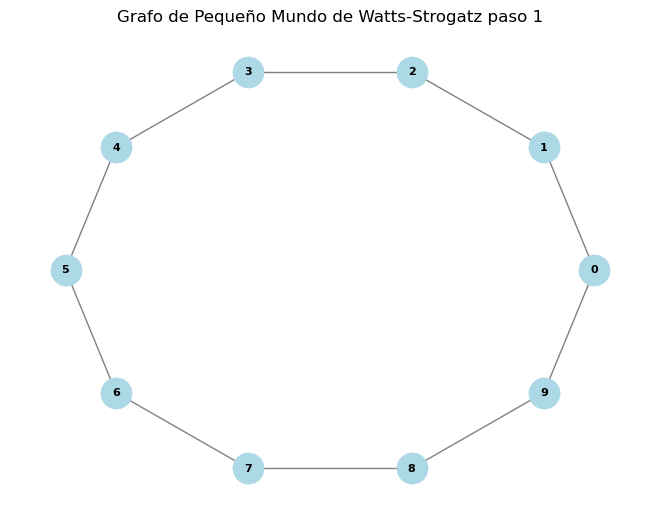

In [2]:
import matplotlib.pyplot as plt
import random

def grafo_anillo_inicial(N):
    G = nx.cycle_graph(N)
    return G

N = 10

# Paso 1: Comenzar con un anillo de N nodos
grafo = grafo_anillo_inicial(N)

# Visualización

nx.draw_circular(grafo, with_labels=True, node_size=500, node_color="lightblue", font_size=8, font_color="black", font_weight="bold", edge_color="gray", linewidths=0.5)
plt.title("Grafo de Pequeño Mundo de Watts-Strogatz paso 1")
plt.show()



## Conectar cada nodo con sus $k$ vecinos más cercanos

Utilizaremos aritmética modular para lograr esto. Como ejemplo, supongamos que $k$ es 4. Entonces, para el nodo $n$, queremos agregar aristas a los 4 vecinos más cercanos de $n$: $n-1, n+1, n-2,$ y $n+2.$ Dado que nuestros nodos están en un círculo, estos pueden "envolverse", por ejemplo, los 4 vecinos más cercanos del nodo 0 son N-1, 1, N-2 y 2.

Observa el uso de la división entera (//) a continuación. La división entera descarta la parte fraccionaria de la división, por ejemplo,



```
5 // 2 = 2
```



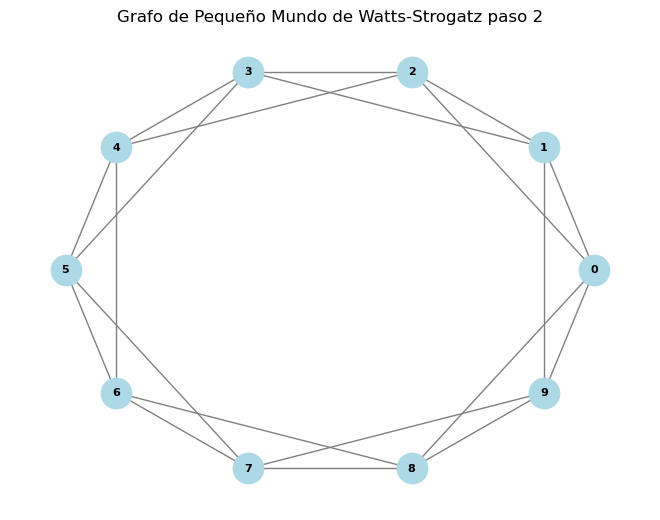

In [3]:

# Paso 2: Conectar cada nodo a sus k vecinos más cercanos

def conectar_vecinos(G, k):

    for n in G.nodes:
      for i in range(1, k // 2 + 1):
          left  = (n-i) % N
          right = (n+i) % N
          G.add_edge(n, left)
          G.add_edge(n, right)


k = 4
conectar_vecinos(grafo, k)
# Visualización
nx.draw_circular(grafo, with_labels=True, node_size=500, node_color="lightblue", font_size=8, font_color="black", font_weight="bold", edge_color="gray", linewidths=0.5)
plt.title("Grafo de Pequeño Mundo de Watts-Strogatz paso 2")
plt.show()




## Reconfigurar algunas aristas

Para cada arista $(u, v)$, con probabilidad $p$, reemplazar la arista $(u, v)$ con (u, w) donde $w$ no es vecino de $u$.

Para este paso, hacemos uso de la aritmética de conjuntos para generar una lista de nodos que no son vecinos de $u$, y `random.choice` para seleccionar $w$ al azar de ese conjunto de "no vecinos".

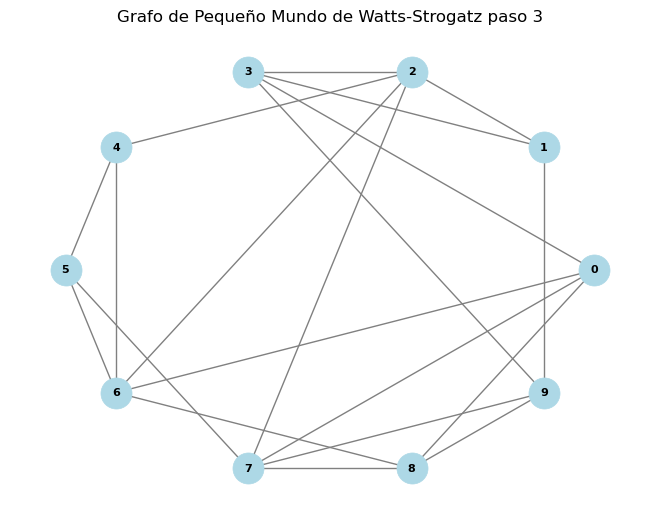

In [4]:
p = 0.4
# Paso 3: Para cada arista (u, v), con probabilidad p, reemplazar la arista (u, v) con (u, w)
def reconfigurar_aristas(G, p):
    for u, v in list(G.edges):
      if random.random() < p:
          not_neighbors = set(G.nodes) - set(G.neighbors(u)) - set([u])
          w = random.choice(list(not_neighbors))
          G.remove_edge(u, v)
          G.add_edge(u, w)

reconfigurar_aristas(grafo, p)

# Visualización
nx.draw_circular(grafo, with_labels=True, node_size=500, node_color="lightblue", font_size=8, font_color="black", font_weight="bold", edge_color="gray", linewidths=0.5)
plt.title("Grafo de Pequeño Mundo de Watts-Strogatz paso 3")
plt.show()

# Función Generadora de Grafos Watts-Strogatz

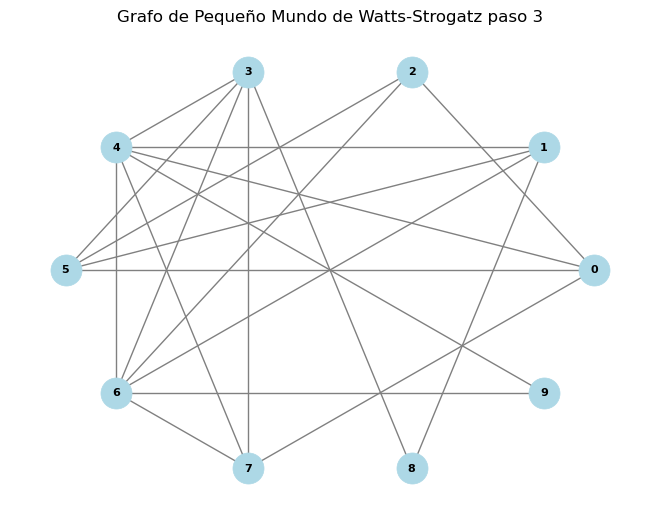

In [5]:
def watts_strogatz_graph(N, k, p):

  grafo = grafo_anillo_inicial(N) # Paso 1
  conectar_vecinos(grafo, k) # Paso 2
  reconfigurar_aristas(grafo, p) # Paso 3

  return grafo

N = 10
k = 4
p = 0.9
grafo =  watts_strogatz_graph(N, k, p)
nx.draw_circular(grafo, with_labels=True, node_size=500, node_color="lightblue", font_size=8, font_color="black", font_weight="bold", edge_color="gray", linewidths=0.5)
plt.title("Grafo de Pequeño Mundo de Watts-Strogatz paso 3")
plt.show()

## Functión NetworkX

NetworkX tiene una función para crear estos modelos: [watts_strogatz_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html).

# Modelo de Configuración

El modelo de configuración busca tomar un grafo seleccionado de manera uniforme dentro de todos aquellos que comparten la misma configuración de grados (dada por la secuencia de grados de los nodos de G).

El modelo de configuración es el más utilizado como hipótesis nula cuando queremos testear propiedades de un grafo. De esta manera, podemos estimar la probabilidad de que un grafo tenga la propiedad que vemos en un grafo real tomando una muestra representativa de grafos con la misma configuración de grados.


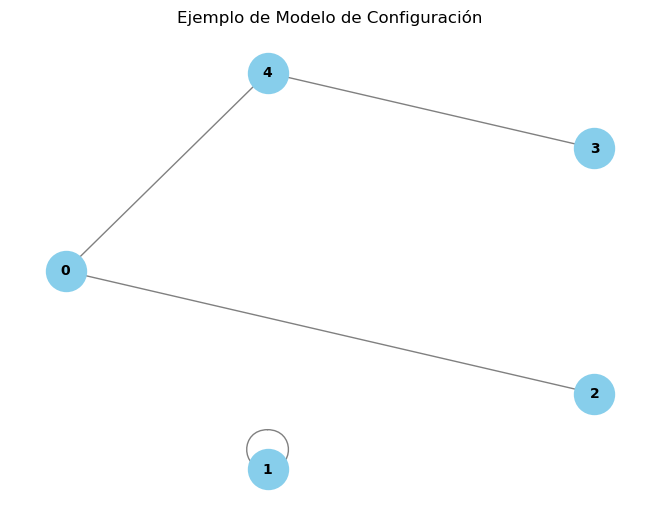

In [6]:
# Secuencia de grados deseada
degree_sequence = [2, 2, 1, 1, 2]

# Crear un grafo vacío
G = nx.Graph()

# Configuración del modelo
G = nx.configuration_model(degree_sequence, create_using=G)

# Visualización
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=800, node_color="skyblue", font_size=10, font_color="black", font_weight="bold", edge_color="gray", linewidths=1.5)

plt.title("Ejemplo de Modelo de Configuración")
plt.show()


# Modelo de Preferential Attachment

El modelo de preferential attachment de Barabási-Albert tiene dos parámetros: el número de nodos $N$ y el número de enlaces agregados en cada paso $m$. Dados estos parámetros, el algoritmo es el siguiente:



1.   Comenzar con un cliqué de $m + 1$ nodos.
2.   Seleccionar $m$ nodos diferentes al azar, ponderados por su grado.
3.   Agregar un nuevo nodo $i$ y vincularlo con los $m$ nodos del paso anterior.
4.   Repetir 2-3 hasta que haya $N$ nodos en el grafo.



El código para esto es bastante directo, con una posible excepción:
para el paso 3, necesitamos generar una secuencia de grados para ponderar la selección aleatoria. Si tenemos un grafo G, podemos generar dicha secuencia de grados con una comprensión de lista de la siguiente manera:

[4, 1, 1, 1, 1]


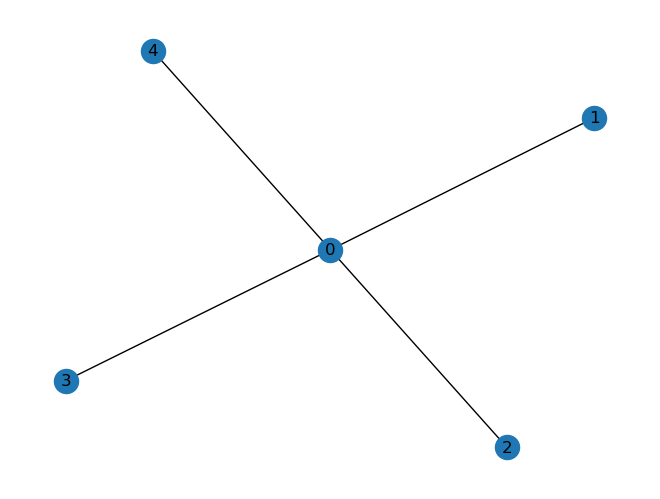

In [7]:
G = nx.star_graph(4)
degrees = [G.degree(n) for n in G.nodes]

print(degrees)
nx.draw(G, with_labels=True)

Observa que la secuencia de grados se produce en el mismo orden que los nodos, de modo que el nodo en el índice $i$ de esa lista tiene el grado en el índice $i$ de la secuencia de grados correspondiente. Con esto, podemos escribir una función para el modelo de preferential attachment de Barabási-Albert:

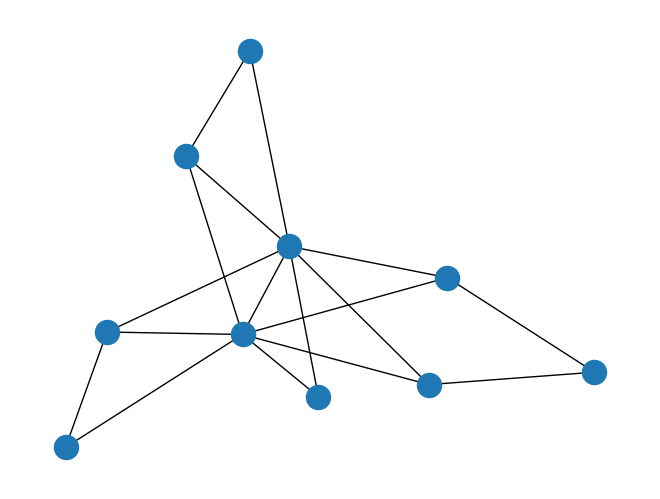

In [8]:
def barabasi_albert_graph(N, m):
    # 1. Comenzar con un cliqué de $m + 1$ nodos.
    G = nx.complete_graph(m + 1)
    for i in range(G.number_of_nodes(), N):
        # 2. Seleccionar $m$ nodos diferentes al azar, ponderados por su grado.
        new_neighbors = []
        possible_neighbors = list(G.nodes)
        for _ in range(m):
            degrees = [G.degree(n) for n in possible_neighbors]
            j = random.choices(possible_neighbors, degrees)[0]
            new_neighbors.append(j)
            possible_neighbors.remove(j)

        # 3. Agregar un nuevo nodo $i$ y vincularlo con los $m$ nodos del paso anterior.
        for j in new_neighbors:
            G.add_edge(i, j)

    return G

N = 10
m = 2
G = barabasi_albert_graph(N, m)
nx.draw(G)

Uno podría preguntarse por qué, en el código anterior para `preferential_attachment_graph`, no escribimos simplemente el paso 2 como

```python
new_neighbors = random.choices(G.nodes, degrees, k=m)
```

El problema aquí es que cuando se especifica $k > 1$ para `random.choices`, la selección se realiza con reemplazo, es decir, el mismo nodo puede ser seleccionado de la lista varias veces. Un código más complicado es necesario para que elijamos $m$ nodos diferentes para unirse al nodo $i$.

### Función de NetworkX

Como en todos estos modelos de grafos, NetworkX tiene una función para generar un modelo BA: [barabasi_albert_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html).




# Rank Model
Rank model es un modelo derivado del de Barabási-Albert donde la distribución de probabilidades con que elegimos a los nodos al momento de agregar conexiones no depende necesariamente de los grados del grafo. Para esto, definimos un ranking arbitrario de los nodos del grafo node_rank (R).
$$p_\alpha (v,G,R) = \dfrac{R(v)^{-\alpha}}{\sum_{u\in V(G)} R(u)^{-\alpha}}$$

Lamentablemente este modelo no esta en la librería NetworkX, pero acá mostramos una opción para implementar el método.

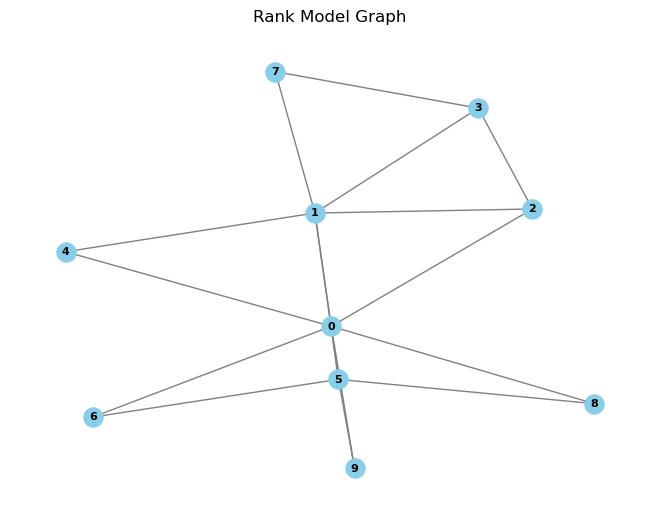

In [9]:
import numpy as np
def rank_model_graph(N, m, node_ranks, alpha= 1):
    # Iniciar un grafo con un pequeño número de nodos y enlaces
    G = nx.complete_graph(m + 1)

    for i in range(m + 1, N):

        # Calcular las probabilidades proporcionales al rango de grado
        probabilities = [1/node_ranks[node]**alpha for node in G.nodes()]
        total_probability = sum(probabilities)
        probabilities = [prob / total_probability for prob in probabilities]

        # Seleccionar m nodos existentes según las probabilidades calculadas
        new_neighbors = np.random.choice(list(G.nodes()), size=m, replace=False, p=probabilities)
        # Agregar el nuevo nodo y conectarlo con los nodos seleccionados
        G.add_node(i)
        G.add_edges_from([(i, neighbor) for neighbor in new_neighbors])

    return G

# Ejemplo de uso
N = 10
m = 2
node_ranks = {i: i+1 for i in range(N)} # Ejemplo de Ranking por orden
alpha = 1 # Mayor alpha promueve que los números menores esten más conectados

rank_model_graph = rank_model_graph(N, m, node_ranks, alpha)

# Visualización
pos = nx.spring_layout(rank_model_graph)
nx.draw(rank_model_graph, pos, with_labels=True, node_size=200, node_color="skyblue", font_size=8, font_color="black", font_weight="bold", edge_color="gray", linewidths=0.5)

plt.title("Rank Model Graph")
plt.show()


# Modelo de camintas aleatorias.
El modelo de caminatas aleatoria busca complementar la falencia que tiene el modelo de Barabási-Albert para generar triángulos y así tener altos niveles de coeficiente de clusterización.

Para parámetros fijos $m$  , una probabilidad $p$  y una cantidad de nodos deseada $N$ :
1.   Comenzamos con una red aleatoria pequeña.
2.    Agregamos un nuevo nodo con $m$  conexiones colgando. La primera conexión de este nodo es conectada con un nodo elegido de manera aleatoria $v$ . Para las siguientes conexiones, con probabilidad $p$ conectamos con algún vecino de $v$  (elegido de manera aleatoria) o con probabilidad $1-p$ conectamos con cualquier otro nodo del grafo escogido de manera aleatoria
3.   Repetimos Paso 2 hasta que el grafo tenga $N$ nodos:

Lamentablemente este modelo no esta en la librería NetworkX, pero acá mostramos una opción para implementar el método.

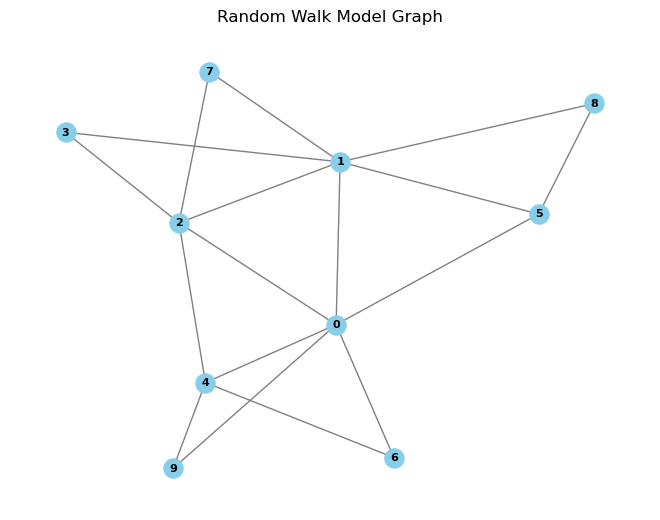

In [10]:
def random_walk_model(N, m, p):
    # Iniciar un grafo con un pequeño número de nodos y enlaces
    G = nx.complete_graph(m + 1)

    for i in range(m + 1, N):
        # Seleccionar m nodos existentes de manera aleatoria
        random_neighbors = random.sample(list(G.nodes()), 1)
        vecinos = [n for n in G.neighbors(random_neighbors[0])]
        for j in range(m-1):
            if random.random()<p:
              nodos_candidatos = [elemento for elemento in vecinos if elemento not in random_neighbors]
              random_neighbors += random.sample(nodos_candidatos, 1)
            else:
              nodos_candidatos = [elemento for elemento in list(G.nodes()) if elemento not in random_neighbors]
              random_neighbors += random.sample(nodos_candidatos, 1)
        # Agregar el nuevo nodo y conectarlo con los nodos seleccionados
        G.add_node(i)
        G.add_edges_from([(i, neighbor) for neighbor in random_neighbors])

    return G

# Ejemplo de uso
N = 10
m = 2
p = 1
random_walk_model_graph = random_walk_model(N, m, p)

# Visualización
pos = nx.spring_layout(random_walk_model_graph)
nx.draw(random_walk_model_graph, pos, with_labels=True, node_size=200, node_color="skyblue", font_size=8, font_color="black", font_weight="bold", edge_color="gray", linewidths=0.5)

plt.title("Random Walk Model Graph")
plt.show()